# Performing NCGR at a gridpoint
* This notebook walks you through how to use the `ncgr` library to perform non-homogenous Gaussian regression (NCGR) on an ice-free date or freeze-up date ensemble forecast at a single location using the `ncgr.calibrate_gridpoint` function. 

* This option is **useful if you *don't want* to rely on NetCDF dependencies** that are required in order to perform NCGR on a 2-D georeferenced grid using the `ncgr.calibrate_fullfield` function. 

* You should have already installed the `NCGR` package (https://github.com/adirkson/sea-ice-timing) before running this notebook. 

* The first section of this notebook, **Bare-bones code**, just offers a copy and pasteable section of code that loads some hindcast and observation data and performs NCGR with `ncgr.ncgr_gridpoint.calibrate_gridpoint`.

* The second section of the notebook, **Detailed explanation & plotting** goes through step-by-step and provides insights on each piece of code, as well as on the data, and creates plots showing the results.


## Bare-bones code

### Case 1
This is for when NCGR is performed *with* a reference climatology provided. Doing so allows for the calculation of forecast probabilities relative to the given reference period for the climatology. 

```python
from NCGR import ncgr
import sitdates

import numpy as np

# load data
X_all = np.load('Data/fud_X.npy') 
Y_all = np.load('Data/fud_Y.npy') 

# define time variables
event='fud' 
years_all = np.arange(1979, 2017+1)
im=12 # initialization month

si_time = sitdates.sitdates(event=event)
a = si_time.pre_occurence(im)
b = si_time.non_occurence(im)

# the forecast year to calibrate (NOTE: this has to be later than 1987 in order for the  rest of the
# code to work. If set to an earlier year, remove the Y_clim variable)
t=2006 

t_idx = np.where(years_all==t)[0][0]
tau_t = years_all[years_all!=t] # years used for training
X_tau_t = X_all[years_all!=t,:] # training hindcasts
Y_tau_t = Y_all[years_all!=t] # training observations
X_t = X_all[t_idx] # forecast to be calibrated
Y_t = Y_all[t_idx] # the observed freeze-up date corresponding to the forecast

Y_clim = Y_all[t_idx-n_clim:t_idx] 

# instantiate class
ncgr_curr = ncgr.ncgr_gridpoint(X_tau_t, Y_tau_t, X_t, tau_t, t,
                                a, b,
                                Y_clim=Y_clim, disp=False)
# calibrate
result = ncgr_curr.calibrate_gridpoint()

# unpack result
mu_cal, sigma_cal, fcst_probs, clim_terc, ens_mean, ens_mean_anom = result.T 
```

### Case 2
This is for when NCGR is performed *without* a reference climatology provided. 

```python
from NCGR import ncgr
import sitdates

import numpy as np

# load data
X_all = np.load('Data/fud_X.npy') 
Y_all = np.load('Data/fud_Y.npy') 

# define time variables
event='fud' 
years_all = np.arange(1979, 2017+1)
im=12 # initialization month

si_time = sitdates.sitdates(event=event)
a = si_time.pre_occurence(im)
b = si_time.non_occurence(im)

# the forecast year to calibrate (NOTE: this has to be later than 1987 in order for the  rest of the
# code to work. If set to an earlier year, remove the Y_clim variable)
t=2006 

t_idx = np.where(years_all==t)[0][0]
tau_t = years_all[years_all!=t] # years used for training
X_tau_t = X_all[years_all!=t,:] # training hindcasts
Y_tau_t = Y_all[years_all!=t] # training observations
X_t = X_all[t_idx] # forecast to be calibrated
Y_t = Y_all[t_idx] # the observed freeze-up date corresponding to the forecast


# instantiate class
ncgr_curr = ncgr.ncgr_gridpoint(X_tau_t, Y_tau_t, X_t, tau_t, t,
                                a, b)
# calibrate
result = ncgr_curr.calibrate_gridpoint()

# unpack result (note fewer output than case 1)
mu_cal, sigma_cal = result.T 
```

## Detailed explanation & plotting

This provides the details for case 1 above. We'll start by importing the various libraries used throughout this notebook:

In [1]:
from NCGR import ncgr
from NCGR.dcnorm import dcnorm_gen
import NCGR.sitdates as sitdates

from scipy.stats import pearsonr
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

We won't use this variable for a little while, but we're defining the year of the forecast to be calibrated here so you can easily find it later to change the value:

In [2]:
t = 2015 # the forecast year to calibrate (change this to see the results for a different year)

Load some sample hindcast and observation data and print the dimensions:

In [3]:
X_all = np.load('Data/fud_X.npy') 
Y_all = np.load('Data/fud_Y.npy') 

years_all = np.arange(1979, 2017+1)

The array `X_all` contains 39 years of *freeze-up date* hindcasts (first dimension) at a single gridpoint in the Bering Sea. These hindcasts were initialized on December 1 and span from 1979-2017 (hence the new array introduced `years_all` which contains those same years). The second dimension of `X_all` contains the 10 ensemble members. Likewise, the array `Y` contains the corresponding observed freeze-up dates for the same location.

We'll now just get a sense of the data by plotting the hindcast and observed time series, and a scatterplot of their values.

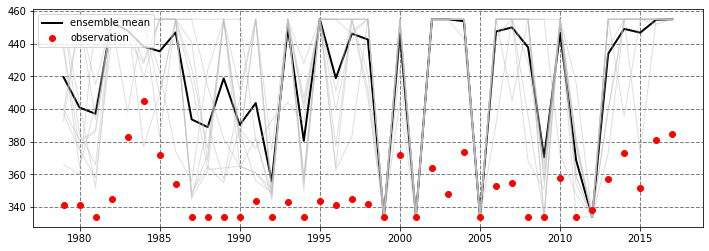

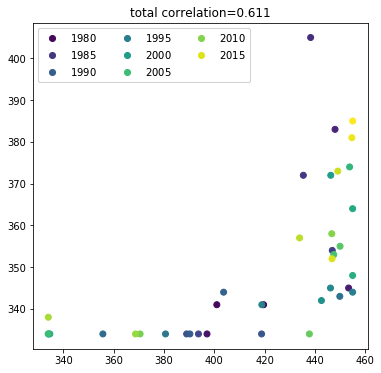

In [4]:
fig = plt.figure(num=1, figsize=(12,4))
ax1 = fig.add_subplot(111)
ax1.plot(years_all, X_all.mean(axis=1), 'k-', linewidth=2, label='ensemble mean') 
ax1.plot(years_all, X_all, '0.75', alpha=0.5, linewidth=1)
ax1.plot(years_all, Y_all, 'ro', label='observation')
ax1.grid(linestyle='--',color='0.5',linewidth=1.0)
ax1.legend(loc='upper left')

fig = plt.figure(num=2, figsize=(6,6))
ax2 = fig.add_subplot(111)
scatter = ax2.scatter(X_all.mean(axis=1), Y_all, c=years_all, cmap='viridis')
ax2.set_title("total correlation=%s" %str(np.around(pearsonr(X_all.mean(axis=1), Y_all)[0],3)))
legend = ax2.legend(*scatter.legend_elements(),
                    loc="upper left", ncol=3)
ax2.add_artist(legend)
plt.show()

For this particular case, the forecast freeze-up date typically occurs much later than the when observed freeze-up date occurs. However, there appears to be a relatively strong correlation between the ensemble mean and the observation.

We'll now create some variables that will be given as arguments to the `ncgr.ncgr_gridpoint` function.

In [5]:
event='fud' 

im=12 # initialization month

si_time = sitdates.sitdates(event=event)
a = si_time.pre_occurence(im)
b = si_time.non_occurence(im)
print("a=%d, b=%d"%(a,b))

a=334, b=455


In the above section of code, we've made use of the `sidates` module by instantiating it with the event variable (in this case 'fud' for *freeze-up date*). By doing so, and by calling on the `si_time.pre_occurence` and `si_time.non_occurence` functions with the given initialization month, the minimum and maximum dates possible are returned. These are printed as `a=334` and `b=455`. Reading the documentation for `sidates` you'll see that default dates are set to those given in [1]. 

------------------------------------------------------------------------------------------------------------------
### Useful side-note:
>If rather different conventions are used for your data, you can change the dates associated with the `si_time.pre_occurence` and `si_time.non_occurence` functions >using `si_time.set_min_date()` and `si_time.set_min_date`. For example, for `im=12`, the convention is to >consider the freeze-up date for the same freeze season that the hindcasts are initialized in. If rather your >hindcast and observed data were created so that the freeze-up date is for the following season, you could change >the minimum and maximum dates corresponding to `im=12` accordingly with:
>
>```python
>si_time.set_min_date(im, 538) # corresponding to the start of the freeze season (October 1) for the next year
>si_time.set_max_date(im, 699) # November 30 of the following year (if e.g. the forecast was run for 12 months)
>```
>Those dates are then set and the minimum and maximum dates can be retrieved at any time within the working script using:
>
>```python
>a = si_time.pre_occurence(im)
>b = si_time.non_occurence(im)
```

------------------------------------------------------------------------------------------------------------------

Okay, back to the example in hand. We now need to deside for which year we want to calibrate a forecast, and then split the original data into training data and "test" (i.e. forecast) data. We'll do this following the same cross-validation procedure (i.e. leave-one-out cross validation) and the notation used in [1]:

In [6]:
t_idx = np.where(years_all==t)[0][0]
tau_t = years_all[years_all!=t] # years used for training
X_tau_t = X_all[years_all!=t,:] # training hindcasts
Y_tau_t = Y_all[years_all!=t] # training observations
X_t = X_all[t_idx] # forecast to be calibrated
Y_t = Y_all[t_idx] # the observed freeze-up date corresponding to the forecast

At this point, if you want the NCGR calibration to return calibrated forecast probabilities for early, near-normal, and late freeze-up dates as well the calibrated forecast ensemble-mean anomaly, then we need to define the observed climatological data used for our reference period. For this example, we'll use the 9 years of observations preceding the forecast year using:

In [7]:
Y_clim = Y_all[t_idx-9:t_idx]
np.sort(Y_clim)

array([334., 334., 334., 338., 353., 355., 357., 358., 373.])

The last 9 years of observed freeze up dates are printed above in ascending order.

We'll now instantiate `ncgr.ncgr_gridpoint` with the relevant input arguments, and then actualy perform NCGR calibration with the additional function call:

In [8]:
ncgr_curr = ncgr.ncgr_gridpoint(X_tau_t, Y_tau_t, X_t, tau_t, t,
                                a, b,
                                Y_clim=Y_clim, disp=True)

result = ncgr_curr.calibrate_gridpoint()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.3707133784933205
            Iterations: 12
            Function evaluations: 16
            Gradient evaluations: 12


By setting the `disp` argument to `True`, the optimization message is printed for the minimization of the CRPS. It's recommended for this to be set to `False` if performing this in a loop if you want the code to execute in less time.

Let's unpack the `result` object to get the variables returned from the calibration:

In [9]:
mu_cal, sigma_cal, fcst_probs, clim_terc, ens_mean, ens_mean_anom = result.T

Finally, we'll plot the calibrated forecast distribution and get a sense of how the forecast performed. For this, we'll rely on the `dcnorm` module imported (see the 'DCNORM distribution example.ipynb' notebook for a tutorial on using this module):

/home/arlan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


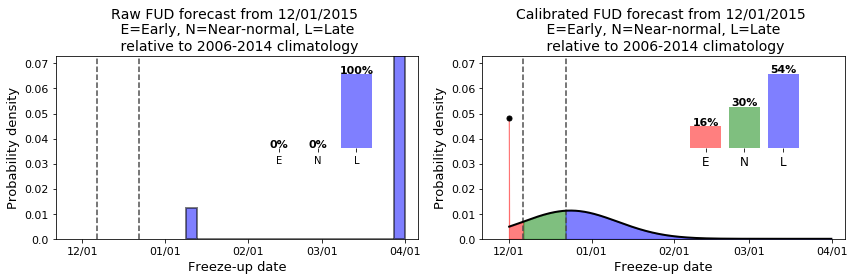

Observed date: 12/19
Observed category: Near normal


In [10]:
#########################################################
######################## PLOTTING #######################
#########################################################
dcnorm = dcnorm_gen(a=a, b=b)
x = np.linspace(a,b,1000)
rv = dcnorm(mu_cal, sigma_cal)

# A way to convert day-of-year dates to regular mm/dd for plot labeling purposes
xticks = []
xticklabels = []
count = a
while count<b+5:
    if count==a:
        # on first iteration, set to init date
        init_doy = si_time.init_doy(im)
        xticks.append(init_doy)
        xticklabels.append(si_time.doy_to_date(init_doy))
    else:
        # otherwise convert to mm/dd if count corresponds to the 1st of the month
        if si_time.doy_to_date(count)[-2:]=='01':
            xticks.append(count)
            xticklabels.append(si_time.doy_to_date(count))
            
    count+=1


fig = plt.figure(figsize=(12,4))
######################## First plot the probability distribution for the raw forecast ################
ax = fig.add_subplot(121)
n, bins, patches = ax.hist(X_t,density=True, edgecolor='k', 
        linewidth=2,bins=20)

# plot climatological terciles as dashed lines
ax.vlines(clim_terc[0],0.0,rv.pdf(x).max()+0.05,colors='0.3', linestyles='--', linewidths=1.5)
ax.vlines(clim_terc[1],0.0,rv.pdf(x).max()+0.05,colors='0.3', linestyles='--', linewidths=1.5)

idx = 0
for c, p in zip(bins, patches):
    if c<=clim_terc[0]:
        plt.setp(p, 'facecolor', 'r',alpha=0.5)
    elif c>=clim_terc[1]:
        plt.setp(p, 'facecolor', 'b',alpha=0.5)
    else:
        plt.setp(p, 'facecolor', 'g',alpha=0.5)
        
    idx+=1
  
# insert axis for bars showing probabilities
ax2 = inset_axes(ax,
                  height="45%", # set height
                  width="45%", # and width
                  bbox_to_anchor=(0.0,0.0,0.95,0.95),
                  axes_kwargs={'frame_on':False},
                  bbox_transform=ax.transAxes)
center=0.5
offset=1.0

# compute forecast probabilities for the raw ensemble
p_en = dcnorm.ecdf(clim_terc[0],X_t)[0]
p_nn = dcnorm.ecdf(clim_terc[1],X_t)[0] - p_en
p_ln = 1 - dcnorm.ecdf(clim_terc[1],X_t)[0]

rect1 = plt.bar(center-offset/2,p_en ,0.4, fc='r',alpha=0.5)
rect2 = plt.bar(center,p_nn, 0.4, fc='g',alpha=0.5)
rect3 = plt.bar(center+offset/2,p_ln, 0.4, fc='b',alpha=0.5)

plt.xlim(-0.5, 1.5)
plt.xticks([center-offset/2,center,center+offset/2])
plt.yticks([])
ax2.set_xticklabels(np.array(['E','N','L']))

ax2.text(center-offset/2, p_en+0.01,str(int(round(p_en*100,0)))+'%', 
       fontsize=11, ha='center',fontweight='semibold')
ax2.text(center, p_nn+0.01,str(int(round(p_nn*100,0)))+'%', 
       fontsize=11, ha='center',fontweight='semibold')
ax2.text(center+offset/2, p_ln+0.01,str(int(round(p_ln*100,0)))+'%', 
       fontsize=11, ha='center',fontweight='semibold')

ax.set_xlim((a-10.,b+5))
ax.set_ylim((0.0,rv.pdf(x).max()+0.05))

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,fontsize=11)
ax.set_yticklabels(np.arange(0.0,rv.pdf(x).max()+0.05,0.01),fontsize=11)
ax.set_ylabel('Probability density', fontsize=13)
ax.set_xlabel('Freeze-up date', fontsize=13)

ax.set_title('Raw '+event.upper()+' forecast from '+"%02d" % im+'/01/'+str(int(t))+' \n E=Early, N=Near-normal, L=Late \n relative to '+str(t-9)+'-'+str(t-1)+' climatology', fontsize=14)



######### Now plot the probability distribution for the calibrated for the calibrated forecast #######
ax = fig.add_subplot(122)
# plot main forecast pdf curve (but exclude end-dates)
ax.plot(x[1:-1], rv.pdf(x[1:-1]), 'k',linewidth=2)
# now plot end-dates if probability exists for pre/non occurence of the event
if rv.pdf(x[0])>1e-4:
    ax.plot(x[0], rv.pdf(x[0]), 'ko', ms=5)
if rv.pdf(x[-1])>1e-4:
    ax.plot(x[-1], rv.pdf(x[-1]), 'ko', ms=5)

# fill colors under the forecast pdf according to each category
ax.fill_between(x[x<clim_terc[0]], 0.0, rv.pdf(x[x<clim_terc[0]]), color='r', alpha=0.5)

ax.fill_between(x[(x>clim_terc[0])&(x<clim_terc[1])], 0.0, 
                  rv.pdf(x[(x>clim_terc[0])&(x<clim_terc[1])]), color='g', alpha=0.5)

ax.fill_between(x[x>clim_terc[1]], 0.0, rv.pdf(x[x>clim_terc[1]]),color='b',alpha=0.5)

# plot climatological terciles as dashed lines
ax.vlines(clim_terc[0],0.0,rv.pdf(x).max()+0.05,colors='0.3', linestyles='--', linewidths=1.5)
ax.vlines(clim_terc[1],0.0,rv.pdf(x).max()+0.05,colors='0.3', linestyles='--', linewidths=1.5)

# insert axis for bars showing probabilities
ax2 = inset_axes(ax,
                  height="45%", # set height
                  width="45%", # and width
                  bbox_to_anchor=(0.0,0.0,0.95,0.95),
                  axes_kwargs={'frame_on':False},
                  bbox_transform=ax.transAxes)

center=0.5
offset=1.0

# plot bars showing probabilities
rect1 = plt.bar(center-offset/2, fcst_probs[0], 0.4, fc='r',alpha=0.5)
rect2 = plt.bar(center, fcst_probs[1], 0.4, fc='g',alpha=0.5)
rect3 = plt.bar(center+offset/2, fcst_probs[2], 0.4, fc='b',alpha=0.5)


plt.xlim(-0.5, 1.5)
plt.xticks([center-offset/2,center,center+offset/2])
plt.yticks([])
ax2.set_xticklabels(np.array(['E','N','L']), fontsize=12)

ax2.text(center-offset/2, fcst_probs[0]+0.01,str(int(round(fcst_probs[0]*100,0)))+'%', 
         fontsize=11, ha='center',fontweight='semibold')
ax2.text(center, fcst_probs[1]+0.01,str(int(round(fcst_probs[1]*100,0)))+'%', 
         fontsize=11, ha='center',fontweight='semibold')
ax2.text(center+offset/2, fcst_probs[2]+0.01,str(int(round(fcst_probs[2]*100,0)))+'%', 
         fontsize=11, ha='center',fontweight='semibold')

ax.set_xlim((a-10.,b+5))
ax.set_ylim((0.0,rv.pdf(x).max()+0.05))

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,fontsize=11)
ax.set_yticklabels(np.arange(0.0,rv.pdf(x).max()+0.05,0.01),fontsize=11)
ax.set_ylabel('Probability density', fontsize=13)
ax.set_xlabel('Freeze-up date', fontsize=13)

ax.set_title('Calibrated '+event.upper()+' forecast from '+"%02d" % im+'/01/'+str(int(t))+' \n E=Early, N=Near-normal, L=Late \n relative to '+str(t-9)+'-'+str(t-1)+' climatology', fontsize=14)

fig.tight_layout()

plt.show()

print("Observed date:", si_time.doy_to_date(int(Y_t)))
if Y_t<=clim_terc[0]:
    print("Observed category: Earlier than normal")
elif (Y_t>clim_terc[0])&(Y_t<=clim_terc[1]):
    print("Observed category: Near normal")
else:
    print("Observed category: Later than normal")
    